# Try opening a kerchunk reference file with virtualizarr 1.3.x and zarr 3.x.x

With v3.x of zarr comes potential breaking changes to the way we use reference files in parquet format - mapping them with fsspec. This notebook confirms that we can at least find a way to open JSON format ref files with the new version.

**Versions:**
* virtualizarr 1.3.2
* zarr         3.0.8
* kerchunk     0.2.8 

In [18]:
# Built-in packages
import os
import sys
import shutil

# Filesystem management 
import fsspec
import earthaccess

# Data handling
import numpy as np
import xarray as xr
from virtualizarr import open_virtual_dataset
import pandas as pd

# Parallel computing 
import multiprocessing
from dask import delayed
import dask.array as da
from dask.distributed import Client
import coiled

# Other
import matplotlib.pyplot as plt

In [2]:
earthaccess.login()

Enter your Earthdata Login username:  deanh808
Enter your Earthdata password:  ········


In [ ]:
fs = earthaccess.get_s3_filesystem(daac="PODAAC")

In [12]:
data = xr.open_dataset(
    "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-docs/ccmp/open/L4_V3.1/docs/CCMP_WINDS_10M6HR_L4_V3.1_combined-ref.json",
    engine="kerchunk",
    chunks={},
    backend_kwargs={
        "storage_options": {
            "remote_protocol": "s3",
            "remote_options": fs.storage_options
        }
    }
)

In [13]:
data

<xarray.Dataset> Size: 775GB
Dimensions:    (time: 46696, latitude: 720, longitude: 1440)
Coordinates:
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * time       (time) datetime64[ns] 374kB 1993-01-02 ... 2024-12-31T18:00:00
Data variables:
    ws         (time, latitude, longitude) float32 194GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    nobs       (time, latitude, longitude) float32 194GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    uwnd       (time, latitude, longitude) float32 194GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vwnd       (time, latitude, longitude) float32 194GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                   CF-1.7 ACDD-1.3
    comment:                       none
    contact:                       Remote Sensing Systems, support@remss.com
    contributor_name:              Carl Mears, Tong Lee, Frank Wentz
    contributor_role:              Principal-Investigator, Co-Investigator, C...
    creator_email:                 support@remss.com
    ...                            ...
    publisher_url:                 https://podaac.jpl.nasa.gov
    references:                    Mears, C.; Lee, T.; Ricciardulli, L.; Wang...
    source:                        blend of satellite and ERA-5 winds
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    summary:                       RSS VAM 6-hour analyses using ERA-5 wind r...
    title:                         RSS CCMP V3.1 6-hourly surface winds (Leve...

In [14]:
%%time

lat_range = (29, 45)
lon_range = (0, 37)
dates = xr.date_range("2020-01-01", periods=1825, unit="s")
data_subset = data.sel(latitude=slice(*lat_range), longitude=slice(*lon_range), time=dates)
data_subset

CPU times: user 918 ms, sys: 52.2 ms, total: 970 ms
Wall time: 969 ms


<xarray.Dataset> Size: 277MB
Dimensions:    (time: 1825, latitude: 64, longitude: 148)
Coordinates:
  * latitude   (latitude) float32 256B 29.12 29.38 29.62 ... 44.38 44.62 44.88
  * longitude  (longitude) float32 592B 0.125 0.375 0.625 ... 36.38 36.62 36.88
  * time       (time) datetime64[ns] 15kB 2020-01-01 2020-01-02 ... 2024-12-29
Data variables:
    ws         (time, latitude, longitude) float32 69MB dask.array<chunksize=(1, 64, 148), meta=np.ndarray>
    nobs       (time, latitude, longitude) float32 69MB dask.array<chunksize=(1, 64, 148), meta=np.ndarray>
    uwnd       (time, latitude, longitude) float32 69MB dask.array<chunksize=(1, 64, 148), meta=np.ndarray>
    vwnd       (time, latitude, longitude) float32 69MB dask.array<chunksize=(1, 64, 148), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                   CF-1.7 ACDD-1.3
    comment:                       none
    contact:                       Remote Sensing Systems, support@remss.com
    contributor_name:              Carl Mears, Tong Lee, Frank Wentz
    contributor_role:              Principal-Investigator, Co-Investigator, C...
    creator_email:                 support@remss.com
    ...                            ...
    publisher_url:                 https://podaac.jpl.nasa.gov
    references:                    Mears, C.; Lee, T.; Ricciardulli, L.; Wang...
    source:                        blend of satellite and ERA-5 winds
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    summary:                       RSS VAM 6-hour analyses using ERA-5 wind r...
    title:                         RSS CCMP V3.1 6-hourly surface winds (Leve...

In [15]:
%%time
ws_mean_map = data_subset["ws"].mean(dim="time").compute()

CPU times: user 1min 12s, sys: 3.97 s, total: 1min 16s
Wall time: 1min 49s


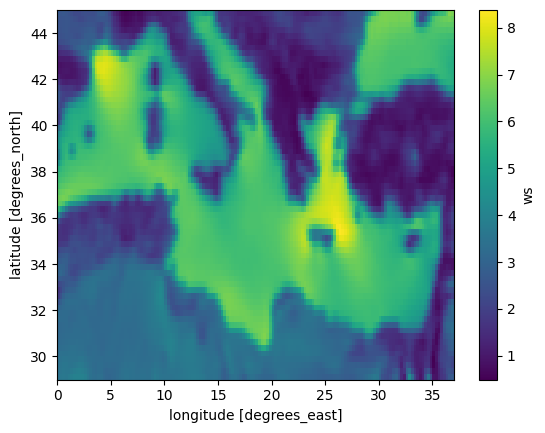

In [19]:
ws_mean_map.plot()